# Urban growth modeling in GRASS GIS: Parallel computing case study
The purpose of this notebook is to demonstrate several parallel computing principles and how they are implemented in GRASS GIS.
We use FUTURES urban growth model implemented as a GRASS GIS addon [r.futures](https://grass.osgeo.org/grass-stable/manuals/addons/r.futures.html).

This notebook uses a [prepared dataset](https://doi.org/10.5281/zenodo.6577922). This dataset is a GRASS GIS Location containing:
 * [NLCD 2001-2019](https://www.mrlc.gov/) (National Land Cover Database; land use and impervious surface descriptor)
 * [US county boundaries](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html)
 * [US-PAD protected areas](https://www.usgs.gov/programs/gap-analysis-project/science/pad-us-data-overview)
 * [USGS DEM](https://www.usgs.gov/3d-elevation-program/about-3dep-products-services)
 
Population files were downloaded from [Zenodo](https://doi.org/10.5281/zenodo.6577903).

All the software is already installed and includes:
 * _GRASS GIS v8.3_ with the following addons: _r.futures, r.mapcalc.tiled, r.sample.category_
 * _R_ with the following packages: _lme4, optparse, MuMIn, snow_
 * _GNU Parallel_
 * _Python 3_ with packages _pandas_
 

<div  class="alert alert-info">This notebook combines Python 3 and Bash cells. By default a code cell is in Python.
We use IPython <a href="https://ipython.readthedocs.io/en/stable/interactive/magics.html#cell-magics">cell magic</a> including `%%bash`, `%%time`, `%%timeit` and `%%writefile`.</div>

## Setting up
The data structure is set up this way
```
~/data
├── grassdata
|   └── FUTURES_SE_USA (location)
│       ├── PERMANENT  (mapset)
│       └── tutorial   (mapset)
├── observed_population_SE_counties_2001-2019.csv
└── projected_population_SE_counties_2020-2100_SSP2.csv

```

Change the current directory to where we have input data:

In [ ]:
import os

os.chdir(os.path.expanduser("~/websites/opengeohub-2023"))

Import Python packages and initialize GRASS GIS session:

In [ ]:
import subprocess
import sys
import pathlib
import json
import pandas as pd
from IPython.display import Image

# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass8", "--config", "python_path"], text=True).strip()
)

# Import GRASS packages
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
session = gj.init("/data/grassdata/", "opengeohub_2023", "part_2")

## Data preprocessing
List dataset layers:

In [ ]:
%%bash
g.list type=raster,vector -p

Display counties using [grass.jupyter.InteractiveMap](https://grass.osgeo.org/grass83/manuals/libpython/grass.jupyter.html):

In [ ]:
m = gj.InteractiveMap()
m.add_vector(name="counties")
m.show()

Set computational region to match counties' extent and aligns with the NLCD raster. Computational region defines the extent and resolution of all raster computations.

In [ ]:
gs.run_command("g.region", vector="counties", align="nlcd_2019")

Now, we will prepocess the data to derive spatial predictors used by the urban growth model in this case study. This diagram shows the workflow and highlights the parts that we will parallelize.

![FUTURES data preparation](FUTURES_case_study_data_prep_opengeohub.svg)

### DEM to slope
Compute slope with [r.slope.aspect](https://grass.osgeo.org/grass-stable/manuals/r.slope.aspect.html) which uses OpenMP for parallelization. For fun, measure the time difference between using 1 or more cores:

In [ ]:
%%timeit -n2 -r3
gs.run_command(
    "r.slope.aspect", elevation="DEM", slope="slope", flags="e", nprocs=1
)

In [ ]:
%%timeit -n2 -r3
gs.run_command(
    "r.slope.aspect", elevation="DEM", slope="slope", flags="e", nprocs=2
)

In [ ]:
m = gj.Map()
m.d_rast(map="slope")
m.d_vect(map="counties", fill_color="none")
m.d_legend(raster="slope", range=[0, 10])
m.show()

### Derive predictors and other layers from NLCD data
Most of our predictors we will derive from NLCD data (land cover type and impervious descriptor products). See [NLCD legend](https://www.mrlc.gov/data/legends/national-land-cover-database-class-legend-and-description) for classification. With [r.reclass](https://grass.osgeo.org/grass-stable/manuals/r.reclass.html) we will create separate layers for water, wetland, forest, roads, and developed land.
Note that those rasters are virtual (they behave the same way, but are only pointing to the original NLCD raster),
so reclassification is very fast.

In [231]:
NLCD_years = [2001, 2004, 2006, 2008, 2011, 2013, 2016, 2019]
NLCD_start_end_years = [2001, 2019]
# water (1 or no data, class 11)
gs.write_command(
    "r.reclass", input="nlcd_2019", output="water", rules="-", stdin="11 = 1"
)
# binary wetlands (classes 90 and 95)
gs.write_command(
    "r.reclass",
    input="nlcd_2019",
    output="wetlands",
    rules="-",
    stdin="90 95 = 1 \n * = 0",
)
# developed land (classes 21 to 24)
for year in NLCD_years:
    gs.write_command(
        "r.reclass",
        input=f"nlcd_{year}",
        output=f"urban_{year}",
        rules="-",
        stdin="21 22 23 24 = 1\n* = 0",
    )
for year in NLCD_start_end_years:
    # forest classes 41 to 43
    gs.write_command(
        "r.reclass",
        input=f"nlcd_{year}",
        output=f"forest_{year}",
        rules="-",
        stdin="41 42 43 = 1",
    )
    # roads classes 20-23 in the descriptor layer
    gs.write_command(
        "r.reclass",
        input=f"nlcd_descriptor_{year}",
        output=f"roads_{year}",
        rules="-",
        stdin="20 21 22 23 = 1",
    )
    # urban without roads (classes 24-26 in the descriptor layer)
    gs.write_command(
        "r.reclass",
        input=f"nlcd_descriptor_{year}",
        output=f"urban_no_roads_{year}",
        rules="-",
        stdin="24 25 26 = 1\n* = 0",
    )

Next, we will compute **distance to water, forest, and roads** (from different years). One of the simplest way to compute these independent tasks in parallel is to run them in the background using Bash by appending &.
Command `wait` forces to wait for the background processes to finish. Adding time in front of wait will report the elapsed time.
Once the distance is computed, we will use raster algebra to transform it logarithmically.

In [ ]:
%%bash
r.grow.distance input=water distance=dist_to_water -m --q &
r.grow.distance input=forest_2001 distance=dist_to_forest_2001 -m --q &
r.grow.distance input=forest_2019 distance=dist_to_forest_2019 -m --q &
r.grow.distance input=roads_2001 distance=dist_to_roads_2001 -m --q &
r.grow.distance input=roads_2019 distance=dist_to_roads_2019 -m --q &
time wait
r.mapcalc "log_dist_to_water = log(dist_to_water + 1)" --q &
r.mapcalc "log_dist_to_forest_2001 = log(dist_to_forest_2001 + 1)" --q &
r.mapcalc "log_dist_to_forest_2019 = log(dist_to_forest_2019 + 1)" --q &
r.mapcalc "log_dist_to_roads_2001 = log(dist_to_roads_2001 + 1)" --q &
r.mapcalc "log_dist_to_roads_2019 = log(dist_to_roads_2019 + 1)" --q &
time wait

For comparison, compute the run time for a single r.grow.distance call:

In [ ]:
%%bash
time r.grow.distance input=water distance=dist_to_water -m --q

In [ ]:
m = gj.Map()
m.d_rast(map="log_dist_to_water")
m.d_vect(map="counties", fill_color="none")
m.show()

As another predictor, we compute **wetland density** (percentage of wetland in 1 km squared circular neighborhood). Module [r.neighbors](https://grass.osgeo.org/grass-stable/manuals/r.neighbors.html) for moving window analysis is internally parallelized using OpenMP, so we can use `nprocs` option:

In [ ]:
%%timeit -n1 -r1
gs.run_command(
    "r.neighbors",
    input="wetlands",
    output="wetland_density",
    size=37,
    method="average",
    flags="c",
    nprocs=4,
)

In [ ]:
m = gj.Map()
m.d_rast(map="wetland_density")
m.d_vect(map="counties", fill_color="none")
m.show()

FUTURES uses a special predictor called development pressure, which can be computed with [r.futures.devpressure](https://grass.osgeo.org/grass-stable/manuals/addons/r.futures.devpressure.html), which is internally parallelized.
Since we need to compute it for 2 years, if we have enough cores, we can use a hybrid approach which runs both commands as background process and each of them runs in parallel.
To do that we split the number of available processes so that each r.futures.devpressure process gets half of the available processes:

In [ ]:
%%bash
r.futures.devpressure input=urban_no_roads_2001 output=devpressure_2001 size=15 gamma=0.5 nprocs=2 scaling_factor=0.1 &
r.futures.devpressure input=urban_no_roads_2019 output=devpressure_2019 size=15 gamma=0.5 nprocs=2 scaling_factor=0.1 &
time wait

In [ ]:
m = gj.Map()
m.d_rast(map="devpressure_2001")
m.show()

### Mask
Compute mask to avoid urban growth simulation in water, protected areas, and outside the study area.
Here we demonstrate data-based parallelization using  [r.mapcalc.tiled](https://grass.osgeo.org/grass-stable/manuals/addons/r.mapcalc.tiled.html). Note that with our relatively small dataset, this approach is going to actually slow down the computation in comparison to simple r.mapcalc call due to overhead from patching the results together. However, for larger dataset, we would be able to see speedup.

In [ ]:
%%timeit -n1 -r1
gs.run_command(
    "r.mapcalc.tiled",
    expression="masking = if((isnull(protected) &&  isnull(water) && nlcd_2019), 1, null())",
    nprocs=4,
)

In [ ]:
%%timeit -n1 -r1
gs.mapcalc("masking = if((isnull(protected) &&  isnull(water) && nlcd_2019), 1, null())")

In [ ]:
m = gj.Map()
m.d_rast(map="masking")
m.show()

## FUTURES simulation
FUTURES simulation has several components to compute how much land is going to be developed, where, and with what size of patches:
![FUTURES diagram](FUTURES.svg)

To keep this workshop on schedule, in this part we will demonstrate the computation of **land demand** using [r.futures.demand](https://grass.osgeo.org/grass-stable/manuals/addons/r.futures.demand.html), then we skip a few steps and proceed with the patch growing simulation. If interested, you can find the skipped steps in `FUTURES_potential_and_calibration.ipynb`.



### Land demand
Here we compute how much land will be developed in each step of the simulation.
Logarithmic curves are fit to per-capita land consumption data derived from NLCD time series and observed population for each county. 

Here we wanted to demonstrate a parallelization approach that splits spatial data into spatial units that are then processed in parallel, and that can be run in a distributed way (on an HPC). Technically, each spatial unit will be processed in a separate GRASS mapset. Distributing of the tasks is done here with GNU Parallel, but that would depend on the specific HPC setup.
While US states would be more appropriate spatial units for this approach (given their size), in this small case study we will apply this approach to counties.
![FUTURES simulation_with highlighted parts of the workflow](FUTURES_case_study_simulation_nosketch_opengeohub.svg)

First, we split and rasterize counties for further parallelization steps:

In [ ]:
# list of all county ids
county_ids = gs.read_command("v.db.select", map="counties", column="FIPS", format="csv", flags="c").splitlines()
print(county_ids)
# use temporary region
gs.use_temp_region()
for fips in county_ids:
    gs.run_command(
        "v.extract",
        input="counties",
        where=f"FIPS == '{fips}'",
        output=f"county_{fips}",
    )
    gs.run_command("g.region", vector=f"county_{fips}", align="nlcd_2019")
    gs.run_command(
        "v.to.rast",
        input=f"county_{fips}",
        output=f"county_{fips}",
        use="attr",
        attribute_column="FIPS",
    )
gs.del_temp_region()
gs.run_command("g.remove", pattern="county_*", type="vector", flags="f")

In [ ]:
m = gj.Map(use_region=True)
m.d_rast(map="county_37183")
m.d_vect(map="counties", attribute_column="FIPS", fill_color="none", label_color="black", xref="center")
m.show()

Then, we create a Python script that takes a county id as an input parameter,
sets the computational region to the county extent, excludes roads from the computation, and runs [r.futures.demand](https://grass.osgeo.org/grass-stable/manuals/addons/r.futures.demand.html),
creating an output CSV needed as input for r.futures.simulation and a plot for visual check.

In [ ]:
%%writefile demand_for_county.py
import sys
import grass.script as gs

# input parameter: state FIPS code
fips = sys.argv[1]

gs.run_command("g.mapsets", mapset="part_2", operation="add")
gs.run_command("g.region", raster=f"county_{fips}")
gs.mapcalc("MASK = if (isnull(roads_2019), 1, null())")
gs.run_command(
    "r.futures.demand",
    subregions=f"county_{fips}",
    development=[
        f"urban_{year}" for year in [2001, 2004, 2006, 2008, 2011, 2013, 2016, 2019]
    ],
    observed_population="observed_population_SE_counties_2001-2019.csv",
    projected_population="projected_population_SE_counties_2020-2100_SSP2.csv",
    simulation_times=list(range(2019, 2051)),
    method="logarithmic",
    demand=f"demand_{fips}.csv",
    plot=f"demand_{fips}.png",
    overwrite=True,
)

For each county we will use Bash scripting to generate grass `--exec` command calling the script within a temporary mapset and append each line to a file `demand_jobs.sh`.
Then, we will run these commands in parallel with GNU Parallel.

<div class="alert alert-info">See <a src="https://www.freecodecamp.org/news/bash-scripting-tutorial-linux-shell-script-and-command-line-for-beginners/">Bash scripting basics</a> 
or other sources to understand bash commands, for loops, or command substitution.</div>

In [232]:
%%bash
# remove the job file (for repeated executions of this cell)
rm -f demand_jobs.sh
# for each of the county ids
for S in $(v.db.select map="counties" column="FIPS" format="csv" -c)
do
    # write "grass ..." command into demand_jobs.sh
    # we will use temporary mapset, no need to store it afterwards
    echo grass8 --tmp-mapset /data/grassdata/opengeohub_2023 --exec python demand_for_county.py ${S} >> demand_jobs.sh
done
# print
cat demand_jobs.sh
# specify number of parallel jobs, reroute error output
parallel -j 2 < demand_jobs.sh 2> log.txt

grass8 --tmp-mapset /data/grassdata/opengeohub_2023 --exec python demand_for_county.py 37037
grass8 --tmp-mapset /data/grassdata/opengeohub_2023 --exec python demand_for_county.py 37063
grass8 --tmp-mapset /data/grassdata/opengeohub_2023 --exec python demand_for_county.py 37069
grass8 --tmp-mapset /data/grassdata/opengeohub_2023 --exec python demand_for_county.py 37077
grass8 --tmp-mapset /data/grassdata/opengeohub_2023 --exec python demand_for_county.py 37085
grass8 --tmp-mapset /data/grassdata/opengeohub_2023 --exec python demand_for_county.py 37101
grass8 --tmp-mapset /data/grassdata/opengeohub_2023 --exec python demand_for_county.py 37105
grass8 --tmp-mapset /data/grassdata/opengeohub_2023 --exec python demand_for_county.py 37127
grass8 --tmp-mapset /data/grassdata/opengeohub_2023 --exec python demand_for_county.py 37135
grass8 --tmp-mapset /data/grassdata/opengeohub_2023 --exec python demand_for_county.py 37145
grass8 --tmp-mapset /data/grassdata/opengeohub_2023 --exec python dema

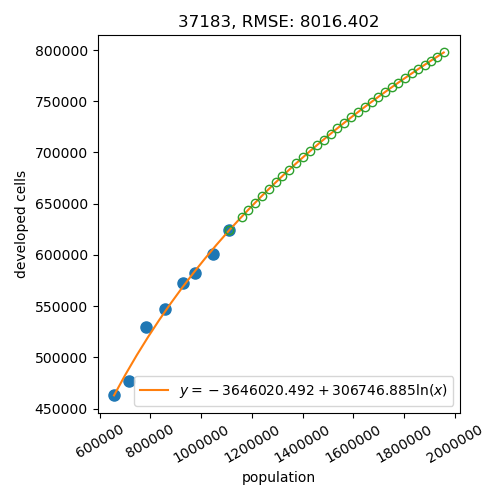

In [233]:
Image("demand_37183.png")

<div class="alert alert-info">At this point, we skip several steps of FUTURES modeling workflow to keep this short and relevant. We will use precomputed files included in the repository. If you are interested in the skipped workflow, see FUTURES_potential_and_calibration.ipynb.</div>

### Patch Growing Algorithm
With [r.futures.simulation](https://grass.osgeo.org/grass-stable/manuals/addons/r.futures.simulation.html) we will run the simulation from 2019 until 2050. r.futures.simulation is stochastic, so with different random seeds, we will get somewhat different result. We will use the same parallelization approach as with r.futures.demand.

First, create a Python script with county id and random seed as an input. The script sets computational region to match the county, turns on the mask, and runs the simulation.


In [ ]:
%%writefile simulation_for_county.py
import sys
import grass.script as gs

fips, seed = sys.argv[1:3]

# g.mapsets for accessing maps from part_2 mapset
gs.run_command("g.mapsets", mapset="part_2", operation="add")
gs.run_command("g.region", raster=f"county_{fips}")
gs.run_command("r.mask", raster="masking")
gs.run_command(
    "r.futures.simulation",
    developed="urban_2019",
    development_pressure="devpressure_2019",
    compactness_mean=0.4,
    compactness_range=0.1,
    discount_factor=0.5,
    predictors=[
        "log_dist_to_forest_2019",
        "log_dist_to_roads_2019",
        "log_dist_to_water",
        "slope",
        "wetland_density",
    ],
    n_dev_neighbourhood=30,
    devpot_params="best_model.csv",
    num_neighbors=4,
    seed_search="probability",
    development_pressure_approach="gravity",
    gamma=0.5,
    scaling_factor=0.1,
    subregions=f"county_{fips}",
    demand=f"demand_{fips}.csv",
    num_steps=31,
    output=f"out_county_{fips}_seed_{seed}",
    patch_sizes=f"patch_sizes_{fips}.csv",
    incentive_power=2,
    random_seed=seed,
)
gs.run_command("r.mask", flags="r")


Similarly, we create a list of commands executing this Python script with a given county and seeds (from 1 to 10).
We will create a new mapset for each command. There will be *number of counties* * *number of random seeds* commands.

In [ ]:
%%bash
rm -f pga_jobs.sh
for SEED in {1..10}
do
    for COUNTY in $(v.db.select map="counties" column="FIPS" format="csv" -c)
    do
        # to start fresh delete the mapset in case it exists from repeated runs.
        rm -rf /data/grassdata/opengeohub_2023/pga_${COUNTY}_${SEED}
        echo grass8 -c /data/grassdata/opengeohub_2023/pga_${COUNTY}_${SEED} --exec python simulation_for_county.py ${COUNTY} ${SEED} >> pga_jobs.sh
    done
done
cat pga_jobs.sh
parallel -j 4 < pga_jobs.sh 2> log.txt

Afterwards, we patch the results from all the counties together. Tool [r.patch](https://grass.osgeo.org/grass-stable/manuals/r.patch.html) is internally parallelized, so we can use that extra speed up if we have available cores. For each seed we will get the list of layers and patch them. This simple loop can be easily parallelized in Python.

<div class="alert alert-warning">Note that Python multiprocessing.Pool examples do not work in an interactive interpreter (such as Jupyter Notebook). That's why we use %run magic to execute Python code as a script.</div>

In [ ]:
%%writefile patch.py

from multiprocessing import Pool
import grass.script as gs


def patch(seed):
    maps = gs.read_command("g.list", type="raster", pattern=f"out_county_*_seed_{seed}",
                           mapset="*", flags="m", separator="comma").strip()
    gs.run_command("r.patch", input=maps, output=f"out_seed_{seed}")

if __name__ == "__main__":
    with Pool(processes=2) as pool:
        pool.map(patch, list(range(1, 11)))
    

In [ ]:
%run patch.py

Set the color ramp of all merged simulation outputs for visualization:

In [ ]:
gs.run_command(
    "r.colors",
    map="out_seed_1",
    raster="out_county_37183_seed_1@pga_37183_1",
)
m = gj.InteractiveMap()
m.add_raster(name="out_seed_1", opacity=0.8)
m.show()

## FUTURES results postprocessing
In this last section we will derive some useful outputs from the stochastic simulation runs.

### Future Development Probability
By aggregating the stochastic runs we can compute the projected development probability. First we reclassify output
to binary developed/undeveloped results. Then we run [r.series](https://grass.osgeo.org/grass-stable/manuals/r.series.html) in parallel to compute how many times a cell was developed
and then divide that by number of runs.

In [ ]:
%%writefile reclass.txt
-1 0 = 0
1 thru 100 = 1
* = 0

In [ ]:
for seed in range(1, 11):
    gs.run_command(
        "r.reclass",
        input=f"out_seed_{seed}",
        output=f"out_seed_{seed}_binary",
        rules="reclass.txt",
    )
gs.run_command(
    "r.series",
    input=[f"out_seed_{seed}_binary" for seed in range(1, 11)],
    output="probability",
    method="sum",
    weights=[0.1] * 10,
    nprocs=2,
)

In [ ]:
# zoom in to see more details
gs.run_command(
    "g.region",
    raster="county_37183",
    save="zoomin",
)
gs.run_command("r.colors", map="urban_2019", color="grey")
m = gj.Map(saved_region="zoomin", width=700)
m.d_background(color="grey")
m.d_rast(map="probability", values="0.2-1")
m.d_rast(map="urban_2019", values=1)
m.show()

### Forest loss analysis
Here we compute future forest loss due to development, demonstrating how to parallelize more complex tasks that require different computational region using Python multiprocessing.
The goal is to compute forest loss for each of 30x30 km tiles in parallel across the landscape to capture large scale forest loss patterns.
To do that we use `GRASS_REGION` environmental variable and set different region for each seed and tile combination.

This Python script includes a function `forest_loss_stats` that for a given tile derives a forest loss layer and counts the number of cells. The function takes as input tile extent and seed, and returns a Python dictionary with tile coordinates, seed, and number of forest cells. Once completed for all tiles, results are written to a JSON file.

The `__main__` function creates the tiles and executes the function for each tile and seed in parallel.

In [ ]:
%%writefile forest_loss.py
import os
import sys
import json
import tqdm
from math import ceil
from multiprocessing import Pool

import grass.script as gs
from grass.exceptions import CalledModuleError


def forest_loss_stats(params):
    """Compute projected forest loss for selected area.
    This function can be safely run in parallel."""
    seed, region = params
    # create unique temporary map names
    forest_loss = f"forest_{seed}_{region['n']}_{region['e']}"
    # copy and modify environment to change region based on input
    env = os.environ.copy()
    env["GRASS_REGION"] = gs.region_env(align="forest_2019", **region)
    # pass the environment, so that the computations run with different region than the current one
    # compute lost forest comparing to 2019
    gs.mapcalc(
        f"{forest_loss} = if (forest_2019 && out_seed_{seed} >= 0, 1, 0)",
        env=env,
        quiet=True,
    )
    # get number of cells for 0 (no change) and 1 (forest lost) category
    results = {"0": 0, "1": 0}
    results.update(dict(
        gs.parse_command(
            "r.stats",
            input=forest_loss,
            flags="an",
            parse=(gs.parse_key_val, {"sep": " ", "val_type": float}),
            env=env,
            quiet=True,
        )
    )
                  )
    # add N, E as a center of the region, and add seed to results
    results["n"] = (region["n"] + region["s"]) / 2
    results["e"] = (region["e"] + region["w"]) / 2
    results["seed"] = seed
    # remove temporary maps
    gs.run_command("g.remove", type="raster", name=forest_loss, flags="f", quiet=True)
    # return dictionary with results
    return results


if __name__ == "__main__":
    current = gs.region()
    regions = []
    tile = 30000  # meter^2
    # create a region where each cell is a tile
    gs.run_command("g.region", res=tile, flags="a", save="tiles")
    env = os.environ.copy()
    env["GRASS_REGION"] = gs.region_env(region="tiles")
    grid_region = gs.region(env=env)
    # save extents of each tile
    for row in range(int(grid_region["rows"])):
        for col in range(int(grid_region["cols"])):
            s = float(grid_region["s"]) + row * float(grid_region["nsres"])
            n = float(grid_region["s"]) + (row + 1) * float(grid_region["nsres"])
            w = float(grid_region["w"]) + col * float(grid_region["ewres"])
            e = float(grid_region["w"]) + (col + 1) * float(grid_region["ewres"])
            regions.append(
                {
                    "n": n,
                    "s": s,
                    "w": w,
                    "e": e,
                }
            )

    params = []
    # collect parameters (for each seed and tile)
    for seed in range(1, 11):
        for region in regions:
            params.append((seed, region))

    # execute forest loss computation for each tile and seed in parallel
    results = []
    with Pool(processes=1) as pool:
        with tqdm.tqdm(total=len(params)) as pbar:
            for result in pool.imap(forest_loss_stats, params):
                results.append(result)
                pbar.update()
        # write results as json to file
        with open("forest_results.json", "w") as f:
            json.dump(results, f)


Execute the file:

In [ ]:
%run forest_loss.py

Load results, process them with Pandas and write a raster:

In [ ]:
with open("forest_results.json", "r") as f:
    results = json.load(f)

df = pd.DataFrame(results)
df = df[df["1"].notna()].groupby(["n", "e"])[["1"]].mean()
df["km"] = df["1"] / 1000000

csv = df.drop(columns=["1"]).to_csv(index=True, header=False)
env = os.environ.copy()
env["GRASS_REGION"] = gs.region_env(region="tiles")
gs.write_command(
    "r.in.xyz",
    stdin=csv,
    input="-",
    x=2,
    y=1,
    output="forest_loss",
    method="mean",
    separator="comma",
    env=env,
)
gs.run_command("r.colors", map="forest_loss", color="grass", flags="n")

Visualize:

In [ ]:
m = gj.Map()
m.d_rast(map="forest_loss")
m.d_vect(map="counties", fill_color="none", color="grey")
m.d_legend(raster="forest_loss", title="Loss of forest [km sq]")
m.show()